In [12]:
import os
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from MAE.util import misc

os.environ["CUDA_VISIBLE_DEVICES"] = '0'

In [2]:
# define the utils
imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def prepare_model(chkpt_dir, arch='mae_vit_base_patch16', random_mask=False, finetune=False):
    # build model
    model = misc.get_mae_model(arch, random_mask=random_mask, finetune=finetune)
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

def run_one_image(img, mask, model):
    x = torch.tensor(img, dtype=torch.float32).cuda()
    mask = torch.tensor(mask, dtype=torch.float32).cuda()

    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)
    mask = mask.reshape(1, 1, mask.shape[0], mask.shape[1])

    # run MAE
    y, mask2 = model.forward_return_image(x.float(), mask)
    y = torch.einsum('nchw->nhwc', y).detach()

    # visualize the mask
    mask = mask.detach()
    mask = mask.repeat(1, 3, 1, 1)
    mask = torch.einsum('nchw->nhwc', mask).detach()
    
    mask2 = mask2.detach()
    mask2 = mask2.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
    mask2 = model.unpatchify(mask2)  # 1 is removing, 0 is keeping
    mask2 = torch.einsum('nchw->nhwc', mask2).detach()
    
    x = torch.einsum('nchw->nhwc', x)
    
    # masked image origin
    im_masked = x * (1 - mask)
    im_masked = im_masked.cpu()

    # masked image
    im_masked2 = x * (1 - mask2)
    im_masked2 = im_masked2.cpu()

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask
    im_paste = im_paste.cpu()
    x = x.cpu()
    y = y.cpu()

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 5, 1)
    show_image(x[0], "original")

    plt.subplot(1, 5, 2)
    show_image(im_masked[0], "masked")
    
    plt.subplot(1, 5, 3)
    show_image(im_masked2[0], "enlarged masked")

    plt.subplot(1, 5, 4)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 5, 5)
    show_image(im_paste[0], "reconstruction + visible")

    plt.show()

In [3]:
# load model
chkpt_dir = 'ckp/places2_wo_norm_pix.pth'
model_mae = prepare_model(chkpt_dir, random_mask=False, finetune=False).cuda()
print('Model loaded.')

<All keys matched successfully>
Model loaded.


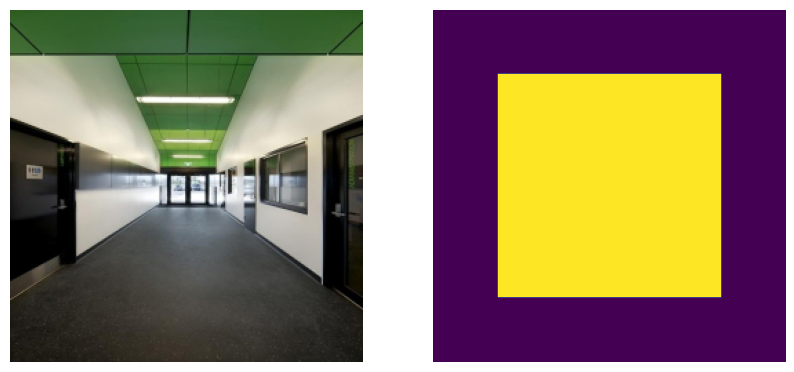

In [4]:
# load an image/mask
img_path = 'MAE/test_img/Places365_val_00000006.jpeg'
mask_path = 'MAE/test_img/rec_mask.png'

img = cv2.imread(img_path)[:,:,::-1]
img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_AREA)
img = np.array(img) / 255.
img = img - imagenet_mean
img = img / imagenet_std
plt.rcParams['figure.figsize'] = [10, 5]
plt.subplot(1,2,1)
show_image(torch.tensor(img))

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
mask = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST)
mask = np.array(mask) / 255.
plt.subplot(1,2,2)
plt.imshow(mask)
plt.axis('off')
plt.show()

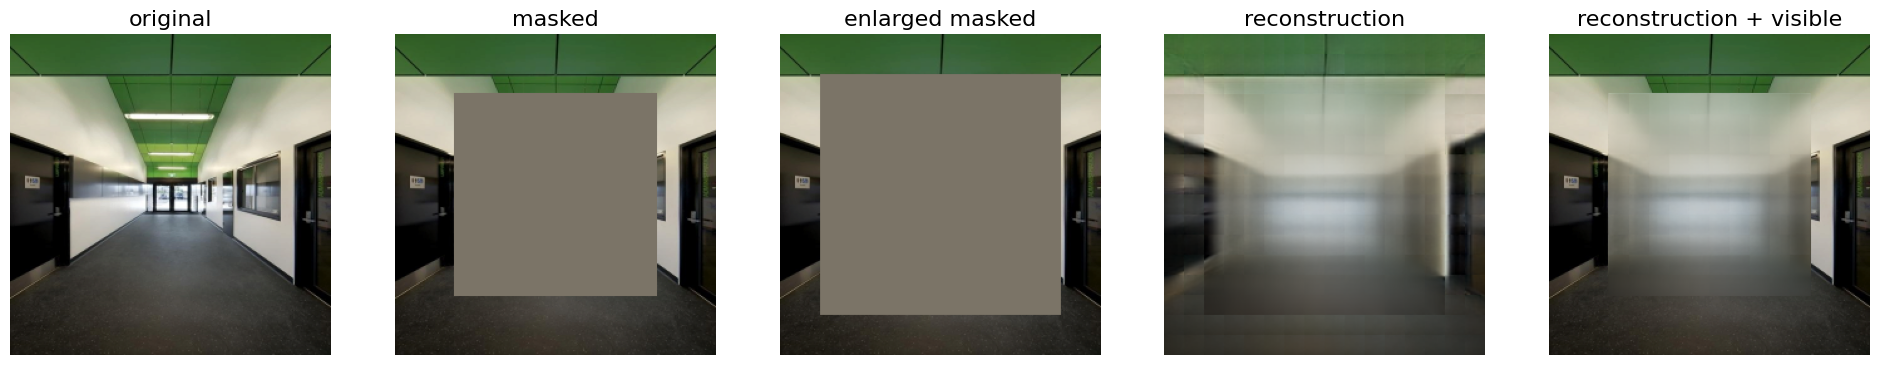

In [ ]:
run_one_image(img, mask, model_mae)

In [7]:
from PIL import Image
import numpy as np
sample_mask = Image.open('/home/daming/workspace/spacely/FurnitureRemove/backend/data/download_ckps/sample/mask.png')

In [16]:
npmask = np.array(sample_mask)
npmask[npmask != 0] = 255

np.unique(npmask, return_counts=True)

(array([  0, 255], dtype=uint8), array([532983,  56841]))

In [15]:
refined_mask = Image.fromarray(npmask)
refined_mask.save('/home/daming/workspace/spacely/FurnitureRemove/backend/data/download_ckps/sample/mask.png')

In [21]:
room1 = Image.open('/home/daming/workspace/spacely/FurnitureRemove/backend/data/imagesample/room1.png')
mask1 = Image.open('/home/daming/workspace/spacely/FurnitureRemove/backend/data/masksample/room1.png')
room1.size

(512, 384)

In [22]:
mask1.size

(512, 384)

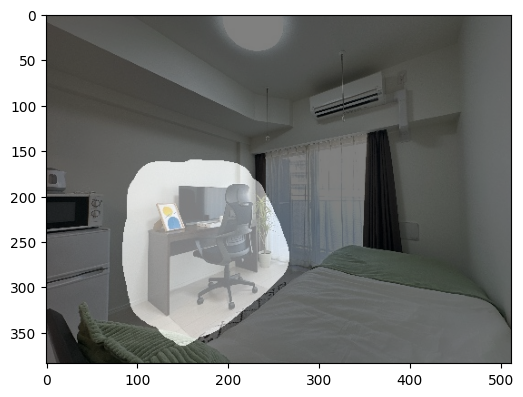

In [20]:
plt.figure(figsize=(6, 6))
plt.imshow(room1)
plt.imshow(mask1, cmap='jet', alpha=0.5)
plt.show()